# IIA 2024 - Aprendizaje Automatizado
### Lucas Poma
## Trabajo Practico 2

## Definiciones

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

### Redes Neuronales

In [2]:
N2 = 20
learning_rate = 0.02
momentum = 0.85
gamma = 0.00001
epochs = 30
evals = 300

In [3]:
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
def MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma):
    return MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate,momentum=momentum,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epochs)

In [5]:
def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_red_peso(red, evaluaciones, X_train, y_train, X_test, y_test):
    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
        red.fit(X_train, y_train)
        weights = red.coefs_
        weight_sum.append(sum(np.sum(np.square(w)) for w in weights))
        error_train.append(error_clasificacion(y_train, red.predict(X_train)))
        error_test.append(error_clasificacion(y_test, red.predict(X_test)))

    return red, error_train, error_test, weight_sum

### Arboles

In [6]:
from sklearn.tree import DecisionTreeClassifier

### Paralelas

In [7]:
def paralelas(n, d, C):
  half = int(n/2)

  mClass0 = np.zeros(d)
  mClass0[0] = 1
  mClass1 = np.zeros(d)
  mClass1[0] = -1
  covM = np.identity(d) * (C**2)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Diagonales

In [8]:
def diagonales(n, d, C):
  half = int(n/2)

  mClass0 = -np.ones(d)
  mClass1 = np.ones(d)
  covM = np.identity(d) * (C**2 * d)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Espirales

In [9]:
def inside_circle(x,y):
  return np.linalg.norm([x,y]) <= 1

def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def in_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def in_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    for i in [1, 3, 5, 7]:
        if in_curve(rho, theta, i):
            return True
    return False

def espirales(n):
  half = int(n/2)
  bothClass = []
  countClass0 = 0
  countClass1 = 0

  while (countClass0 < half or countClass1 < n-half):
    gen = np.random.uniform(-1,1,size=(half,2))
    for (x,y) in gen:
      if (inside_circle(x,y)):
        if (in_curves(x,y)):
          if (countClass0 < half):
            bothClass.append([x,y,0])
            countClass0 += 1
        else:
          if (countClass1 < n - half):
            bothClass.append([x,y,1])
            countClass1 += 1
  df = pd.DataFrame(bothClass, columns=['dim_0', 'dim_1', 'class'])
  return df

## Ejercicio 1

### Setup

In [6]:
dimensiones = [2, 4, 8, 16, 32]
overlap = 0.78
testSamples = 10000
dataParalelasTree = []
dataDiagonalesTree = []
dataParalelasRed = []
dataDiagonalesRed = []
dataParalelasBayes = []
dataDiagonalesBayes = []

### Diagonales

In [9]:
for dimension in dimensiones:
    testDiagonales10000 = diagonales(testSamples, dimension, overlap)
    X_test = testDiagonales10000.drop(columns=['class'])
    y_test = testDiagonales10000['class']

    for conjunto in range(0,20):
        dfDiagonales = diagonales(250, dimension, overlap)
        X = dfDiagonales.drop(columns=['class'])
        y = dfDiagonales['class']

        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataDiagonalesTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataDiagonalesRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataDiagonalesBayes.append([dimension, conjunto, errTest, errEntrenamiento])

### Paralelas

In [11]:
for dimension in dimensiones:
    testParalelas10000 = paralelas(testSamples, dimension, overlap)
    X_test = testParalelas10000.drop(columns=['class'])
    y_test = testParalelas10000['class']

    for conjunto in range(0,20):
        dfParalelas = paralelas(250, dimension, overlap)
        X = dfParalelas.drop(columns=['class'])
        y = dfParalelas['class']
        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataParalelasTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataParalelasRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataParalelasBayes.append([dimension, conjunto, errTest, errEntrenamiento])

### Resultados

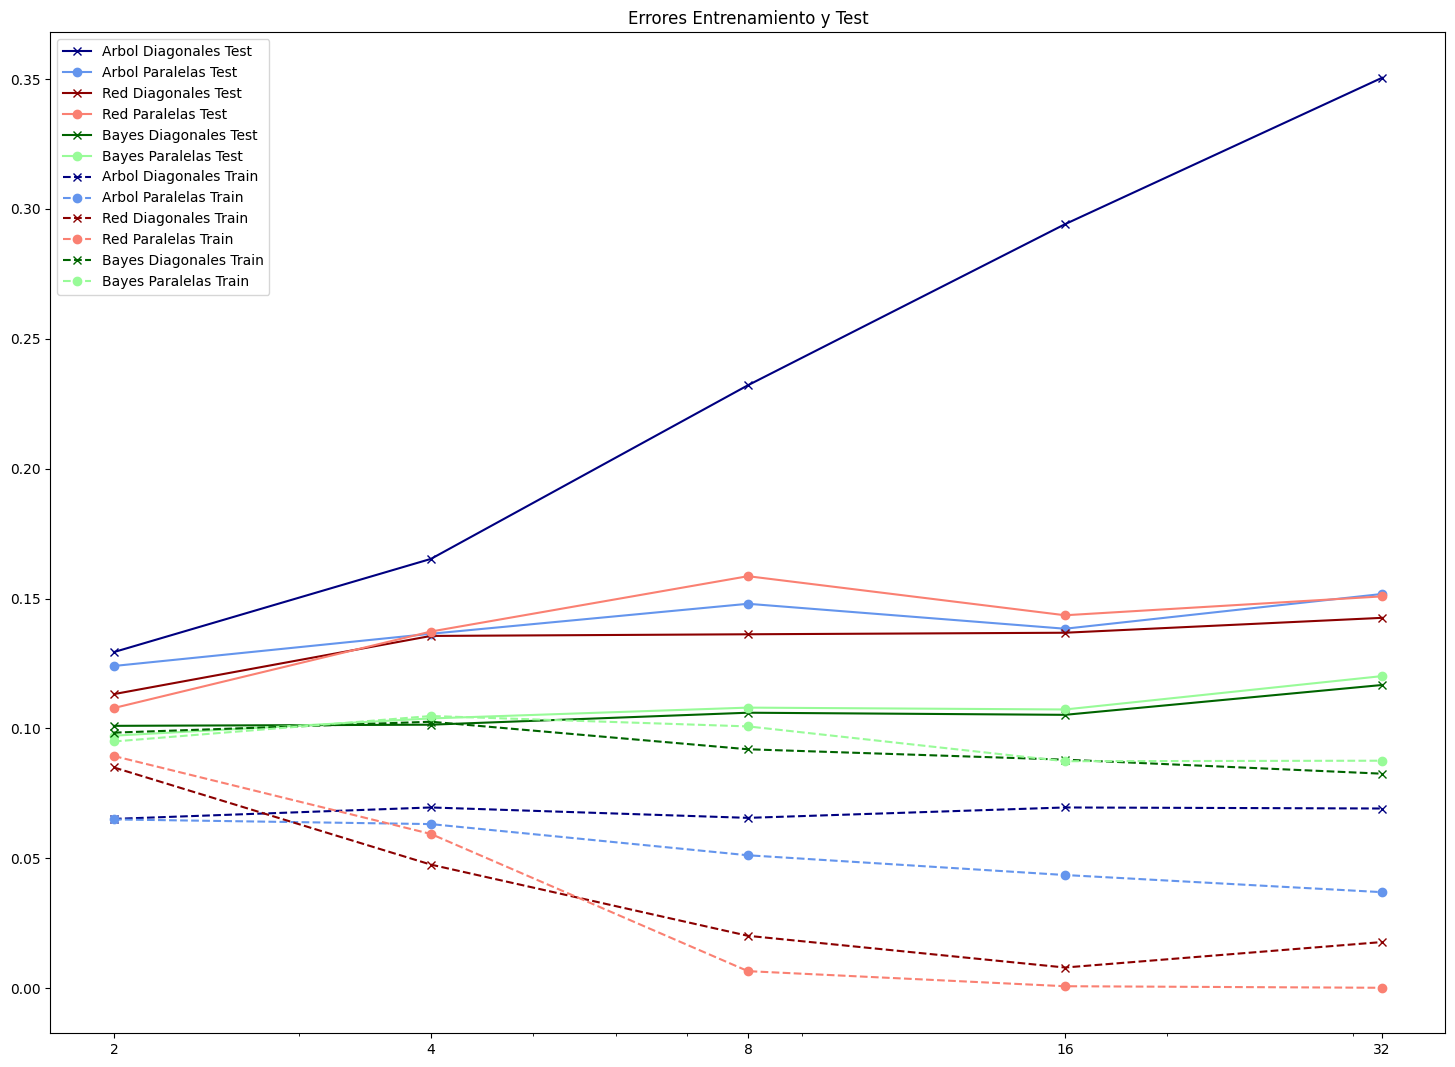

In [12]:
dfDiagonalesTree = pd.DataFrame(dataDiagonalesTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasTree = pd.DataFrame(dataParalelasTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errTest'].mean()
promsErrTestParalelasTree = dfParalelasTree.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasTree = dfParalelasTree.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesRed = pd.DataFrame(dataDiagonalesRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasRed = pd.DataFrame(dataParalelasRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errTest'].mean()
promsErrTestParalelasRed = dfParalelasRed.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasRed = dfParalelasRed.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesBayes = pd.DataFrame(dataDiagonalesBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasBayes = pd.DataFrame(dataParalelasBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errTest'].mean()
promsErrTestParalelasBayes = dfParalelasBayes.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasBayes = dfParalelasBayes.groupby('dimension')['errEntrenamiento'].mean()

plt.figure(figsize=(18, 13))

plt.plot(dimensiones, promsErrTestDiagonalesTree, c='navy', label='Arbol Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasTree, c='cornflowerblue', label='Arbol Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesRed, c='darkred', label='Red Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasRed, c='salmon', label='Red Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasBayes, c='palegreen', label='Bayes Paralelas Test', marker='o', linestyle="-")

plt.plot(dimensiones, promsErrEntrenamientoDiagonalesTree, c='navy', label='Arbol Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasTree, c='cornflowerblue', label='Arbol Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesRed, c='darkred', label='Red Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasRed, c='salmon', label='Red Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasBayes, c='palegreen', label='Bayes Paralelas Train', marker='o', linestyle="--")

plt.legend()
plt.xscale('log')
plt.title('Errores Entrenamiento y Test')
plt.xticks(dimensiones, labels=[str(dimension) for dimension in dimensiones])

plt.show()

El clasificador GaussianNB es una implementación del algoritmo Naive Bayes que asume que las características continuas siguen una distribución normal (gaussiana)
En el caso de GaussianNB, se asume que cada característica sigue una distribución normal
Distribución gaussiana: Asume que las características siguen una distribución normal, lo cual puede no ser cierto en todos los casos.
En resumen, GaussianNB es un clasificador eficaz y eficiente para datos con características que siguen una distribución normal y donde la suposición de independencia es razonable.

## Ejercicio 2

### Dos Elipses

In [18]:
csv = pd.read_csv('DataSets/dos_elipses.data', names=['dim_0', 'dim_1', 'class']).sample(n=500)
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/dos_elipses.test', names=['dim_0', 'dim_1', 'class']).sample(n=2000)
X_test = csv.drop(columns=['class'])
y_test = csv['class']

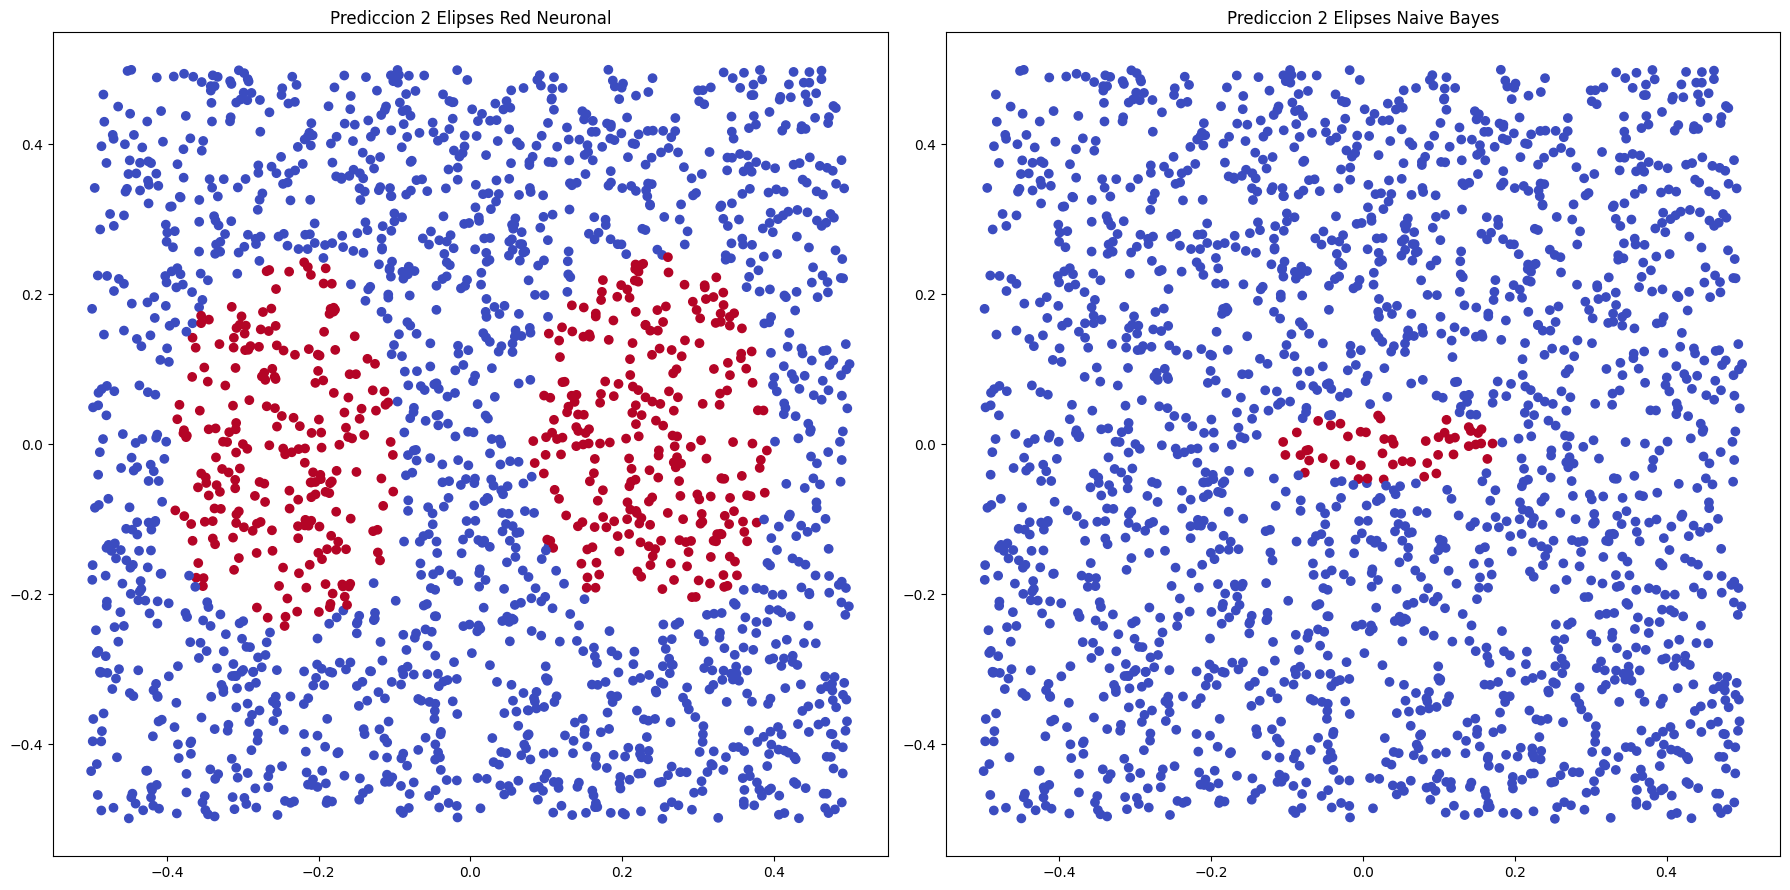

In [19]:
clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
best_red, error_train, error_val, error_test = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_red.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Red Neuronal')

clfb = GaussianNB()
clfb.fit(X, y)
ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=clfb.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Naive Bayes')

plt.tight_layout()
plt.show()

### Espirales

In [68]:
espiralesTrain = espirales(600)
espiralesTest = espirales(2000)

X = espiralesTrain.drop(columns=['class'])
y = espiralesTrain['class']

X_test = espiralesTest.drop(columns=['class'])
y_test = espiralesTest['class']

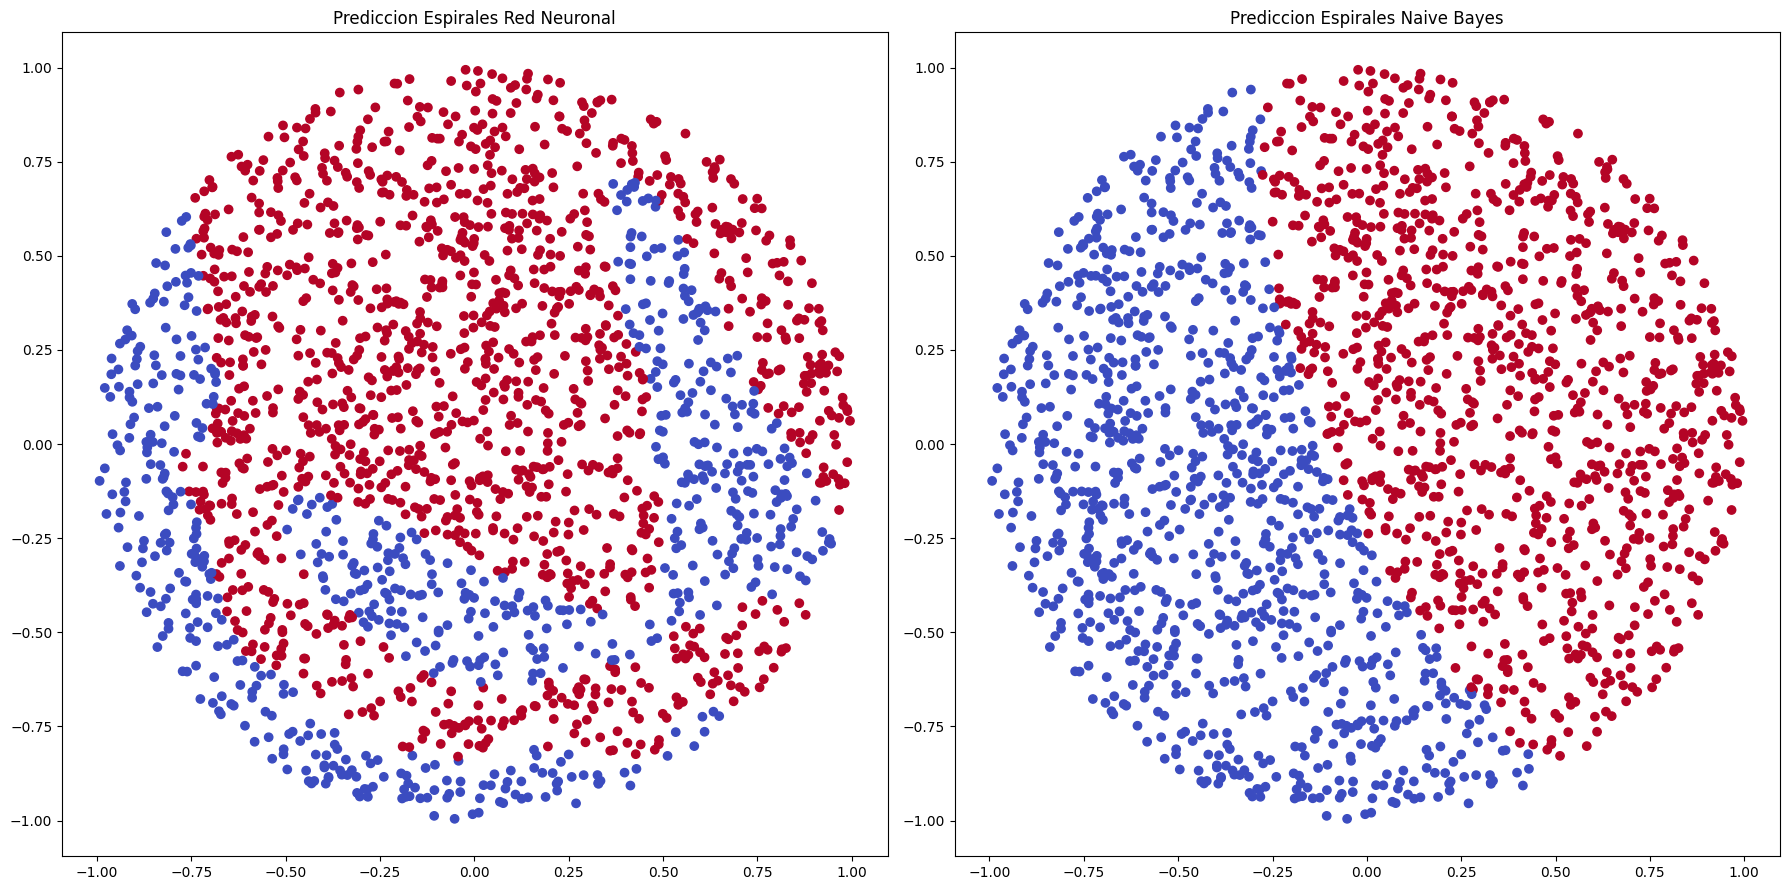

In [21]:
clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
best_red, error_train, error_val, error_test = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_red.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Red Neuronal')

clfb = GaussianNB()
clfb.fit(X, y)
ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=clfb.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Naive Bayes')

plt.tight_layout()
plt.show()

## Ejercicio 3

In [19]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
bins_list = [2*x for x in range(1, 30)]

In [20]:
def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list):
    error_val = []
    error_train = []
    error_test = []
    min_error_val = float('inf')

    for bins in bins_list:
        discretizador = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        clf = CategoricalNB(min_categories=bins)
        X_discreto = discretizador.fit_transform(X_train)
        clf.fit(X_discreto,y_train)
        aux_err_val = error_clasificacion(y_val, clf.predict(discretizador.transform(X_val)))

        if aux_err_val < min_error_val:
            min_error_val = aux_err_val
            best_bayes = copy.deepcopy(clf)
            best_discretizador = copy.deepcopy(discretizador)

        error_val.append(aux_err_val)
        error_train.append(error_clasificacion(y_train, clf.predict(discretizador.transform(X_train))))
        error_test.append(error_clasificacion(y_test, clf.predict(discretizador.transform(X_test))))

    return best_bayes, best_discretizador, error_train, error_val, error_test

In [21]:
def bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, title):
    ax.set_title(title)
    ax.plot(bins_list, error_train, label='Error de Entrenamiento', color='red', linestyle="-")
    ax.plot(bins_list, error_val, label='Error de Validacion', color='blue', linestyle="-")
    ax.plot(bins_list, error_test, label='Error de Test', color='green', linestyle="-")
    ax.set_xticks(bins_list, labels=[str(size) for size in bins_list])
    ax.legend()

## Ejercicio 4

In [22]:
csv = pd.read_csv('DataSets/dos_elipses.data', names=['dim_0', 'dim_1', 'class']).sample(n=500)
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/dos_elipses.test', names=['dim_0', 'dim_1', 'class']).sample(n=2000)
X_test = csv.drop(columns=['class'])
y_test = csv['class']

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2)

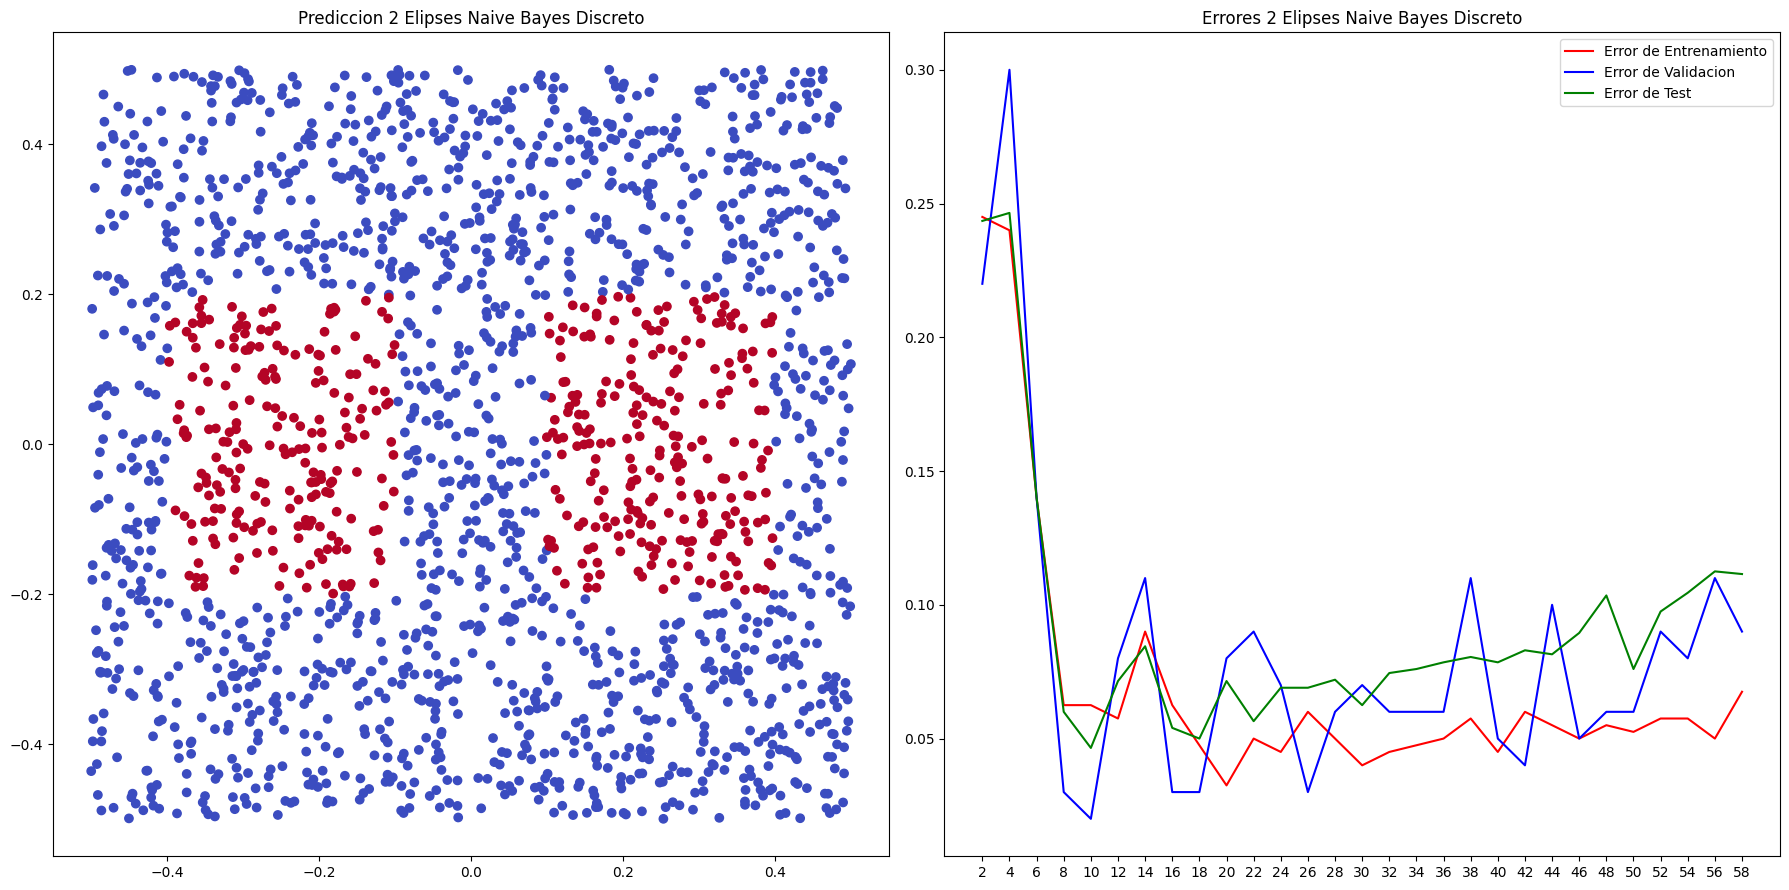

In [23]:
best_bayes, best_disc, error_train, error_val, error_test = entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_bayes.predict(best_disc.transform(X_test)), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Naive Bayes Discreto')

ax = axs[1]
bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, 'Errores 2 Elipses Naive Bayes Discreto')

plt.tight_layout()
plt.show()

In [24]:
espiralesTrain = espirales(600)
espiralesTest = espirales(2000)

X = espiralesTrain.drop(columns=['class'])
y = espiralesTrain['class']

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2)

X_test = espiralesTest.drop(columns=['class'])
y_test = espiralesTest['class']

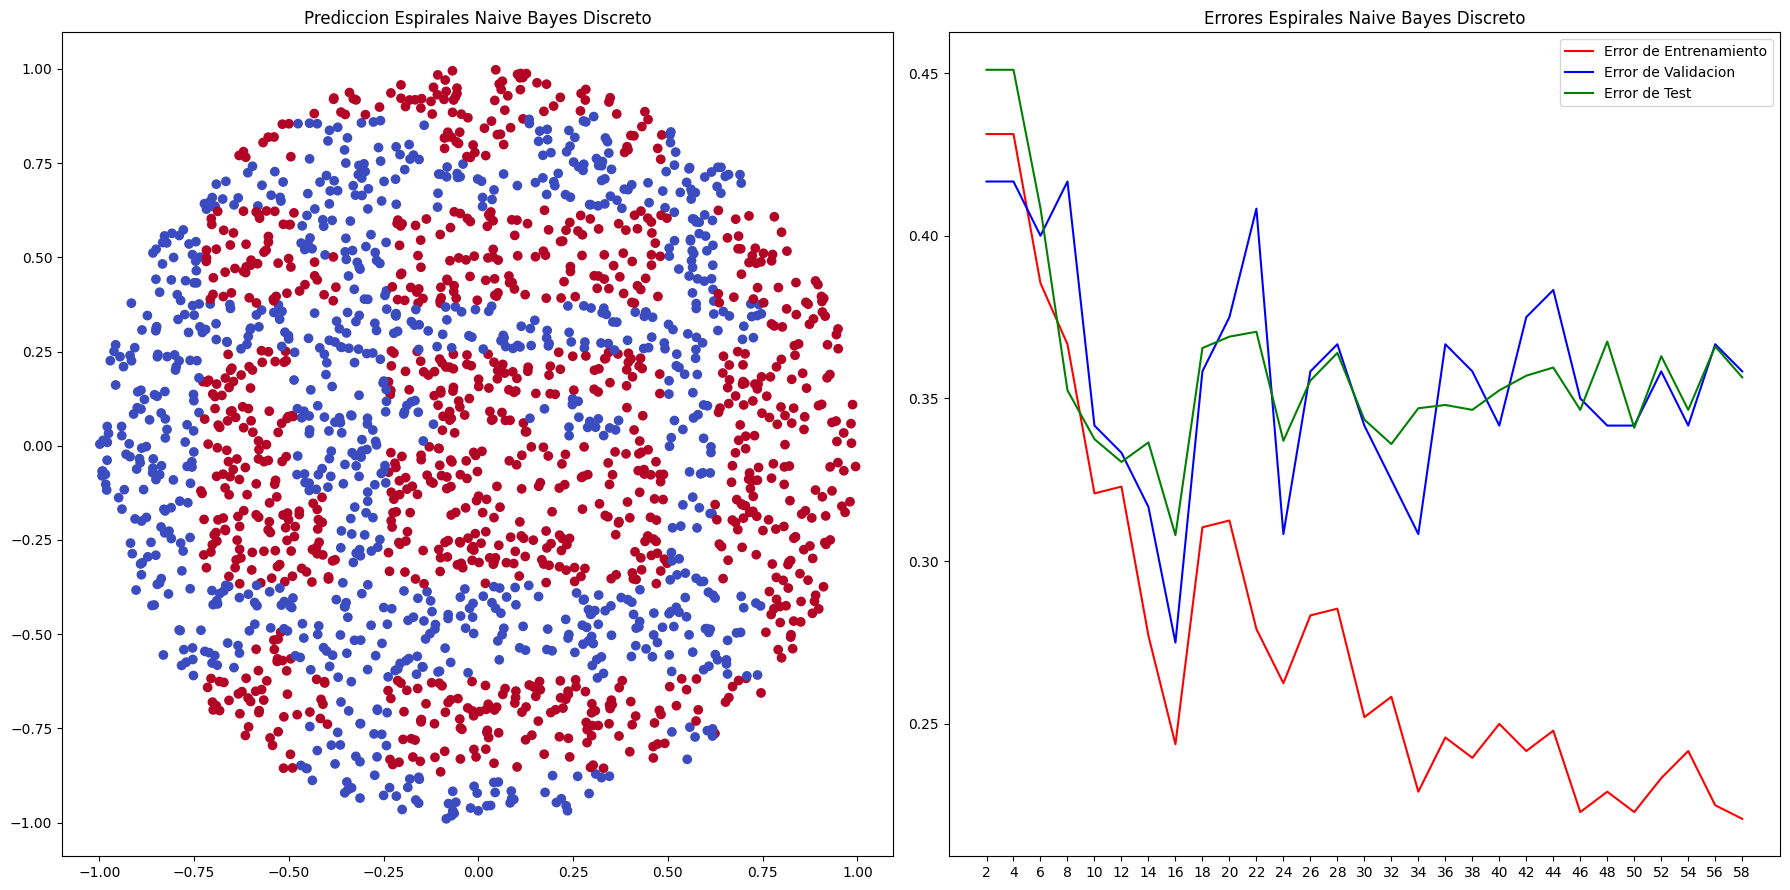

In [25]:
best_bayes, best_disc, error_train, error_val, error_test = entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_bayes.predict(best_disc.transform(X_test)), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Naive Bayes Discreto')

ax = axs[1]
bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, 'Errores Espirales Naive Bayes Discreto')

plt.tight_layout()
plt.show()

 A diferencia de GaussianNB, que asume que las características siguen una distribución normal, CategoricalNB trabaja con datos categóricos y modela la probabilidad condicional de cada característica como una distribución categórica (o multinomial).
 Durante el entrenamiento, CategoricalNB calcula las frecuencias de cada categoría para cada característica en cada clase en el conjunto de datos de entrenamiento. Estas frecuencias se utilizan para estimar las probabilidades condicionales.
 

## Ejercicio 5


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_20newsgroups
X, y = fetch_20newsgroups(subset="train", return_X_y=True, remove=("headers",))
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25)
X_test, y_test = fetch_20newsgroups(subset="test", return_X_y=True, remove=("headers",))

In [26]:
alfas = [(10**(-x)) for x in range(0, 5)]
largos = [500, 1000, 2000, 4000]
data = []

Durante el entrenamiento, MultinomialNB calcula las frecuencias de cada característica para cada clase en el conjunto de datos de entrenamiento. Estas frecuencias se usan para estimar las probabilidades condicionales.

In [27]:
def entrenar_bayes_multi(alfa, X_train, y_train, X_val, y_val, X_test, y_test):
    aux_error_val = float('inf')
    for alfa in alfas:
        for largo in largos:
            vec = CountVectorizer(stop_words='english',max_features=largo)
            Xvec_train = vec.fit_transform(X_train).toarray()
            Xvec_val = vec.transform(X_val).toarray()
            Xvec_test = vec.transform(X_test).toarray()
            clf = MultinomialNB(alpha=alfa)
            clf.fit(Xvec_train, y_train)
            error_val = error_clasificacion(y_val, clf.predict(Xvec_val))
            error_train = error_clasificacion(y_train, clf.predict(Xvec_train))
            error_test = error_clasificacion(y_test, clf.predict(Xvec_test))
            data.append([alfa, largo, error_val, error_train, error_test])

            if error_val < aux_error_val:
                aux_error_val = error_val
                best_bayes = copy.deepcopy(clf) 
                best_vectorizador = copy.deepcopy(vec)
    return best_bayes, best_vectorizador



In [28]:
mejorBayes, mejorVectorizador = entrenar_bayes_multi(alfas, X_train, y_train, X_val, y_val, X_test, y_test)
print("Errores\n")
table = pd.DataFrame(data, columns=['Alfa', 'Largo Dict', 'Error Validacion', 'Error Entrenamiento', 'Error Test'])
print(table)

Errores

      Alfa  Largo Dict  Error Validacion  Error Entrenamiento  Error Test
0   1.0000         500          0.412160             0.377254    0.508099
1   1.0000        1000          0.340756             0.283913    0.420074
2   1.0000        2000          0.279251             0.210489    0.347451
3   1.0000        4000          0.231531             0.158161    0.302045
4   0.1000         500          0.406504             0.371715    0.502788
5   0.1000        1000          0.336868             0.274956    0.415560
6   0.1000        2000          0.269707             0.197879    0.346389
7   0.1000        4000          0.222694             0.138480    0.301115
8   0.0100         500          0.406858             0.369240    0.503717
9   0.0100        1000          0.337222             0.270949    0.415428
10  0.0100        2000          0.271828             0.190100    0.350637
11  0.0100        4000          0.223047             0.127637    0.308285
12  0.0010         500       

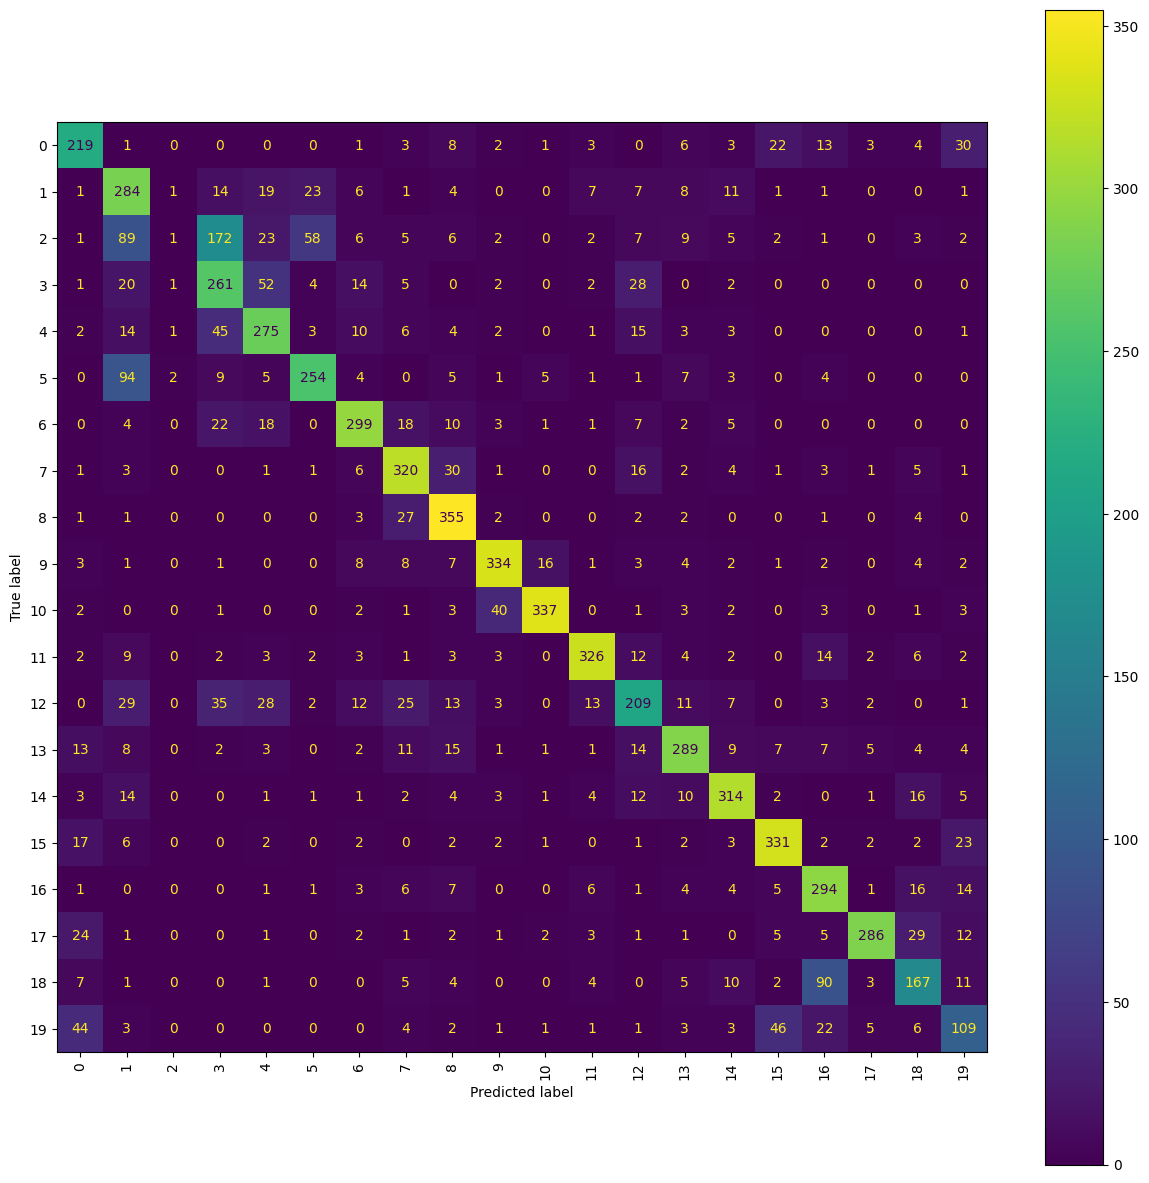

In [29]:
matrix = confusion_matrix(y_test, mejorBayes.predict(mejorVectorizador.transform(X_test)), labels=mejorBayes.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=mejorBayes.classes_)

fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.show()